In [1]:
import os
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import argparse
import json
from datetime import datetime
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from collections import defaultdict
from sklearn.model_selection import train_test_split

import xgboost as xgb
from catboost import CatBoost, Pool

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

from utils.inference_and_explain import *
from utils.result_to_df import *
from models.treeMoE import Model

from xai_utils_ver_a.run_trading import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", device)

fix_seed = 2025
random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(fix_seed)

[INFO] Using device: cuda


In [2]:
# Step 2. Data Loader for XaI
class Dataset_SNP_XAI(Dataset):
    def __init__(self, args, root_path, flag='test', data_path='TSLA.feather',
                 scale=True, stop_loss=0):
        self.args = args
        self.root_path = root_path
        self.data_path = data_path
        self.scale = scale
        self.stop_loss = stop_loss
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_feather(os.path.join(self.root_path, self.data_path))
        df_raw['Date'] = pd.to_datetime(df_raw['Date'])

        # 전체 Close
        self.data_Close_all = df_raw['Close'].values

        # Stock, Close 열 제거 -> 나머지 지표 + Date + Y
        df_raw = df_raw.drop(["Stock"], axis=1)
        df_raw = df_raw.dropna()

        # BUY/SELL -> 1/0
        df_raw[['Y', 'Y_2', 'Y_3', 'Y_4', 'Y_5']] = df_raw[
            ['Y', 'Y_2', 'Y_3', 'Y_4', 'Y_5']
        ].apply(lambda x: x.map({'SELL': 0, 'BUY': 1}))

        # 기간 분할
        num_train = df_raw[(df_raw['Date'] >= '2020-01-01') & (df_raw['Date'] <= '2022-12-31')].shape[0]
        num_vali  = df_raw[(df_raw['Date'] >= '2023-01-01') & (df_raw['Date'] <= '2023-12-31')].shape[0]
        num_test  = df_raw[(df_raw['Date'] >= '2024-01-01')].shape[0]

        border1s = [0, num_train, len(df_raw) - num_test]
        border2s = [num_train, num_train+num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        # X
        df_x = df_raw.drop(['Y','Y_2','Y_3','Y_4','Y_5','Close'], axis=1)
        self.all_dates = df_x['Date'].values
        df_x = df_x.drop(['Date'], axis=1)
        self.feature_names = df_x.columns.tolist()

        # 스케일링 (train구간만 기준)
        if self.scale:
            train_data = df_x[border1s[0]:border2s[0]]
            quantile_train = np.copy(train_data.values).astype(np.float64)
            stds = np.std(quantile_train, axis=0, keepdims=True)
            noise_std = 1e-3 / np.maximum(stds, 1e-3)
            quantile_train += noise_std * np.random.randn(*quantile_train.shape)
            self.scaler = QuantileTransformer(output_distribution='normal', random_state=1004)
            self.scaler.fit(quantile_train)
            data_all = self.scaler.transform(df_x.values)
        else:
            data_all = df_x.values

        self.data_x = data_all[border1:border2]

        # Y
        if self.stop_loss == 0:
            df_y = df_raw[['Y']].values
        elif self.stop_loss == 2:
            df_y = df_raw[['Y_2']].values
        elif self.stop_loss == 3:
            df_y = df_raw[['Y_3']].values
        elif self.stop_loss == 4:
            df_y = df_raw[['Y_4']].values
        elif self.stop_loss == 5:
            df_y = df_raw[['Y_5']].values
        else:
            raise ValueError('stop_loss는 0,2,3,4,5 중 택1')

        self.data_y = df_y[border1:border2]
        self.data_Close = self.data_Close_all[border1:border2]
        self.data_Date = self.all_dates[border1:border2]

    def __getitem__(self, index):
        x = self.data_x[index]
        y = self.data_y[index]
        c = self.data_Close[index]
        d = self.data_Date[index]
        d_str = str(d)  # 문자열 변환
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.long),
            torch.tensor(c, dtype=torch.float32),
            d_str
        )

    def __len__(self):
        return len(self.data_x)


def prepare_data_loader(data, flag='test', stop_loss=0, batch_size=8):
    dataset = Dataset_SNP_XAI(
        args=args,
        root_path='./dataset',
        data_path=data,
        flag=flag,
        scale=True,
        stop_loss=stop_loss,
    )
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    print(f"[INFO] {flag.capitalize()} set size: {len(dataset)}")
    return data_loader
    

In [3]:
# Set hyper param
class Args:
    def __init__(self):
        self.device = device
        self.dim_input = 437
        self.num_classes = 2
        self.alpha_fs = 0.4793517441865507
        self.beta_fs = 0.10397776764986093
        self.max_depth = 5
        self.use_gating_mlp = 1
        self.gating_mlp_hidden = 32        
        self.hidden_dim_expert = 32
        self.anneal_epochs = 30
        self.schedule_type = "linear"
        self.learning_rate = 0.0001
        self.lradj = "type2"
        self.initial_temp = 2.0
        self.final_temp = 0.2

args = Args()


In [6]:
def main(args_cmd):
    args_model = Args()  
    args_model.device = device
    
    model_path = args_cmd.model_path
    model = load_model(args_model, model_path)  
    
    train_loader = prepare_data_loader("TSLA.feather", 'train', args_cmd.stop_loss, args_cmd.batch_size)
    test_loader = prepare_data_loader("TSLA.feather",'test', args_cmd.stop_loss, args_cmd.batch_size)
    
    output_dir = args_cmd.output_dir
    os.makedirs(output_dir, exist_ok=True)
    
    # 변수 중요도 분석
    importance_data = run_feature_importance_analysis( model, test_loader,
                                                      args_cmd.top_k, args_cmd.temperature,
                                                      args_cmd.gating_mode, args_cmd.importance_type, output_dir)
    
    tree_models_data = train_tree_models(train_loader, output_dir)
    
    multi_model_results = evaluate_multi_model_strategies(
        model, tree_models_data, importance_data, 
        args_cmd.gating_mode, args_cmd.temperature, 
        args_cmd.top_k,args_cmd.top_k, args_cmd.top_k,  output_dir
    )
    
    moe_eval_results = run_trading_strategy_evaluation(
        model, importance_data, args_cmd.gating_mode, args_cmd.temperature, args_cmd.top_k, output_dir
    )
    
    print("\n[INFO] Complete analysis finished.")
    return {
        'importance_data': importance_data,
        'tree_models_data': tree_models_data,
        'multi_model_results': multi_model_results,
        'moe_eval_results': moe_eval_results
    }


[INFO] Model loaded from ./checkpoints/treeMoE_TSLA_md5_hde32_al4_be1_mlp1_EXPNEW_0/checkpoint.pth


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(


[INFO] Train set size: 698


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(


[INFO] Test set size: 279
[INFO] Extracting global feature importance (soft gating, both importance)...
[INFO] Extracting leaf-level feature importance...
[INFO] Extracting leaf-level feature influence (gamma * weight)...
[INFO] Importance analysis results saved to ./XAI_results_a
[INFO] Preparing data for tree models...
[INFO] Training XGBoost model with default parameters...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[INFO] Training CatBoost model with default parameters...
[INFO] Tree models trained and saved to ./XAI_results_a
[INFO] Performance comparison saved to ./XAI_results_a/multi_model_performance_20250226_014612.png


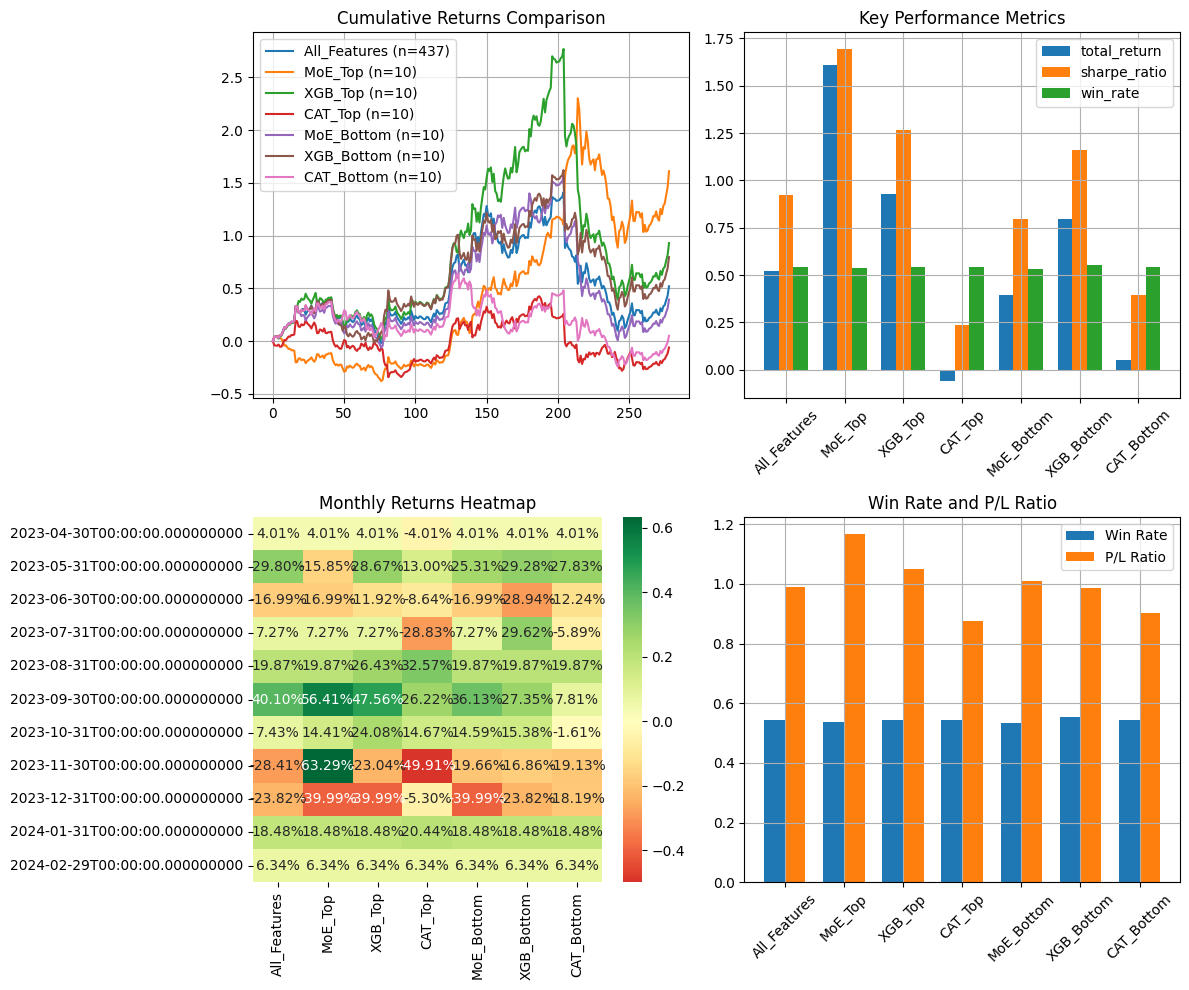

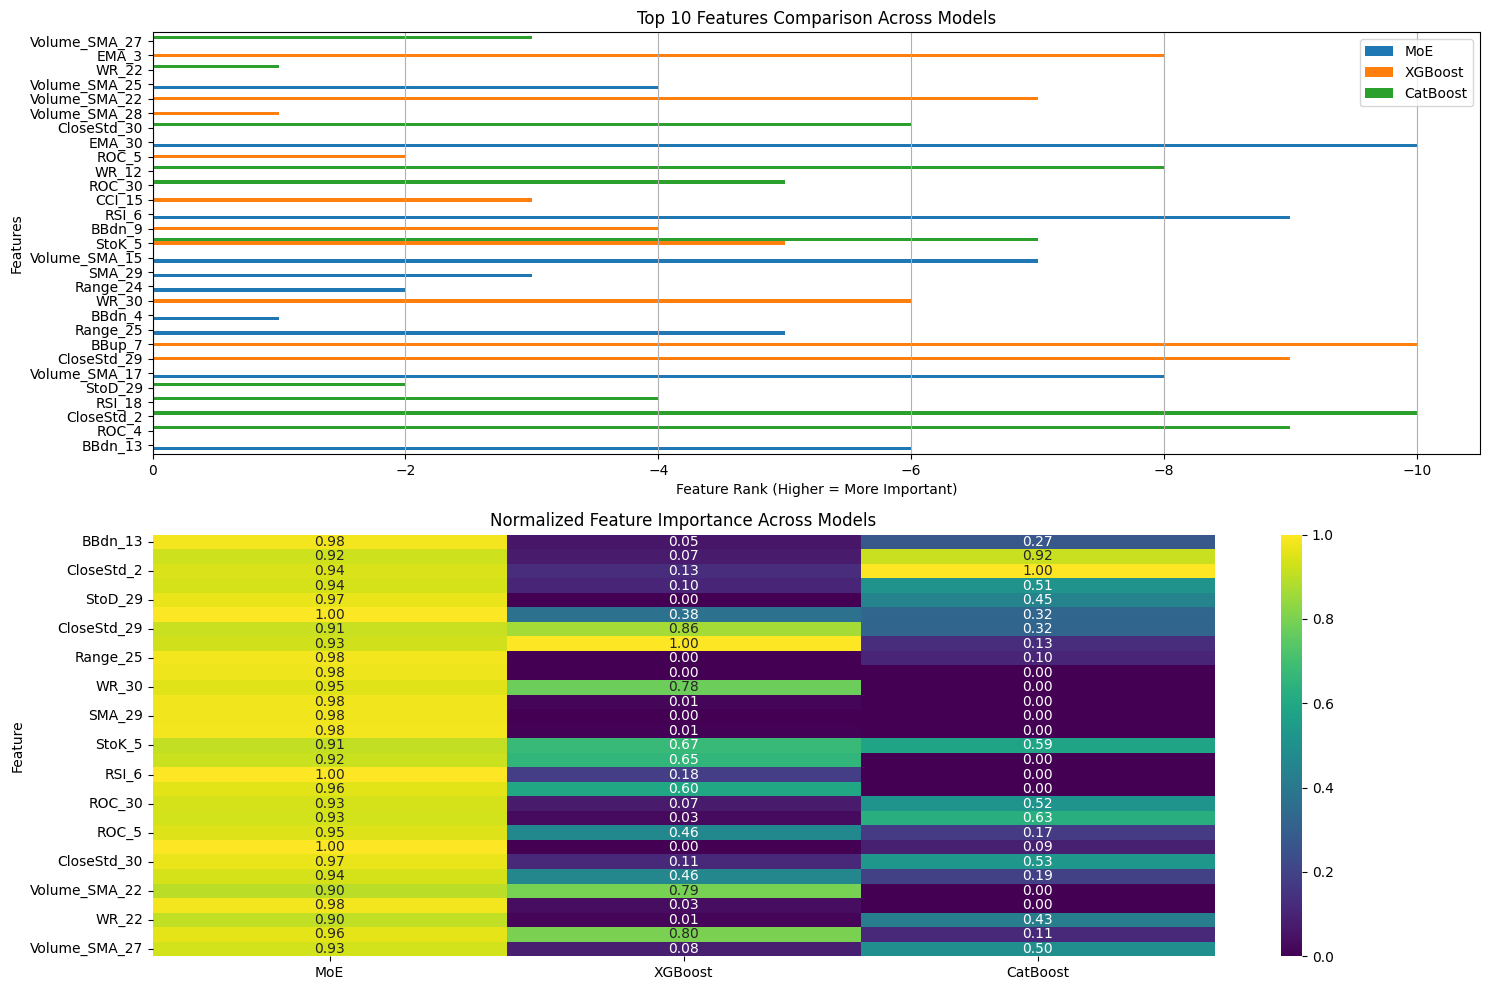

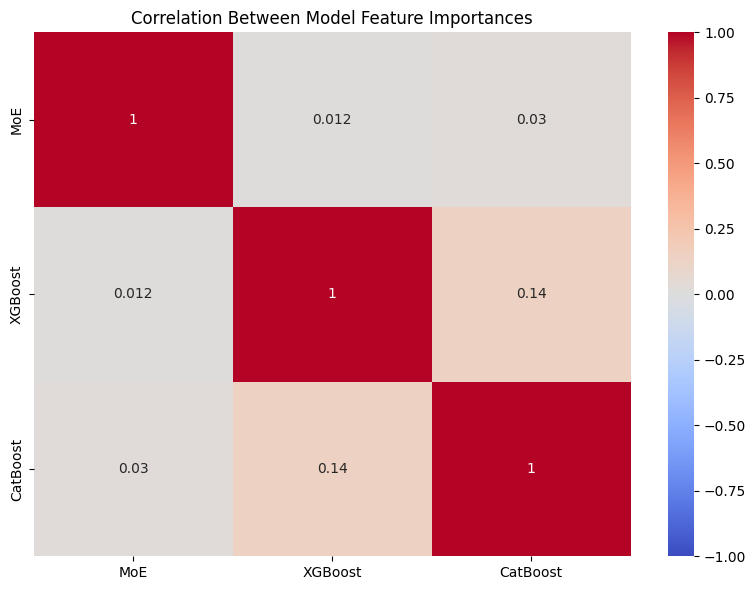

[INFO] Performance comparison saved to ./XAI_results_a/performance_comparison_soft_20250226_014617.png


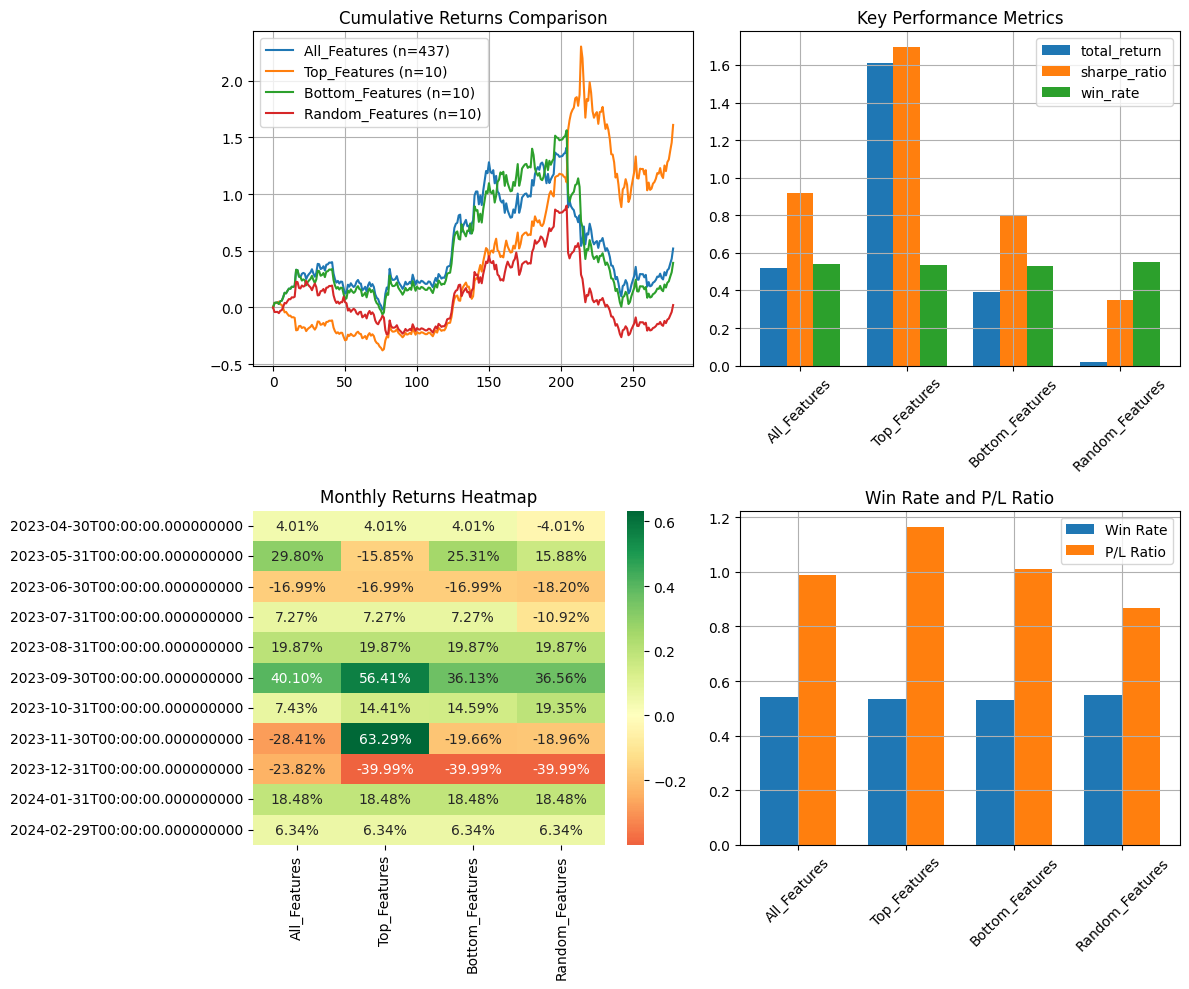

[INFO] Calculating individual feature performance...


100%|██████████| 10/10 [00:00<00:00, 43.46it/s]


[INFO] Calculating pairwise feature interactions...


100%|██████████| 45/45 [00:01<00:00, 43.88it/s]


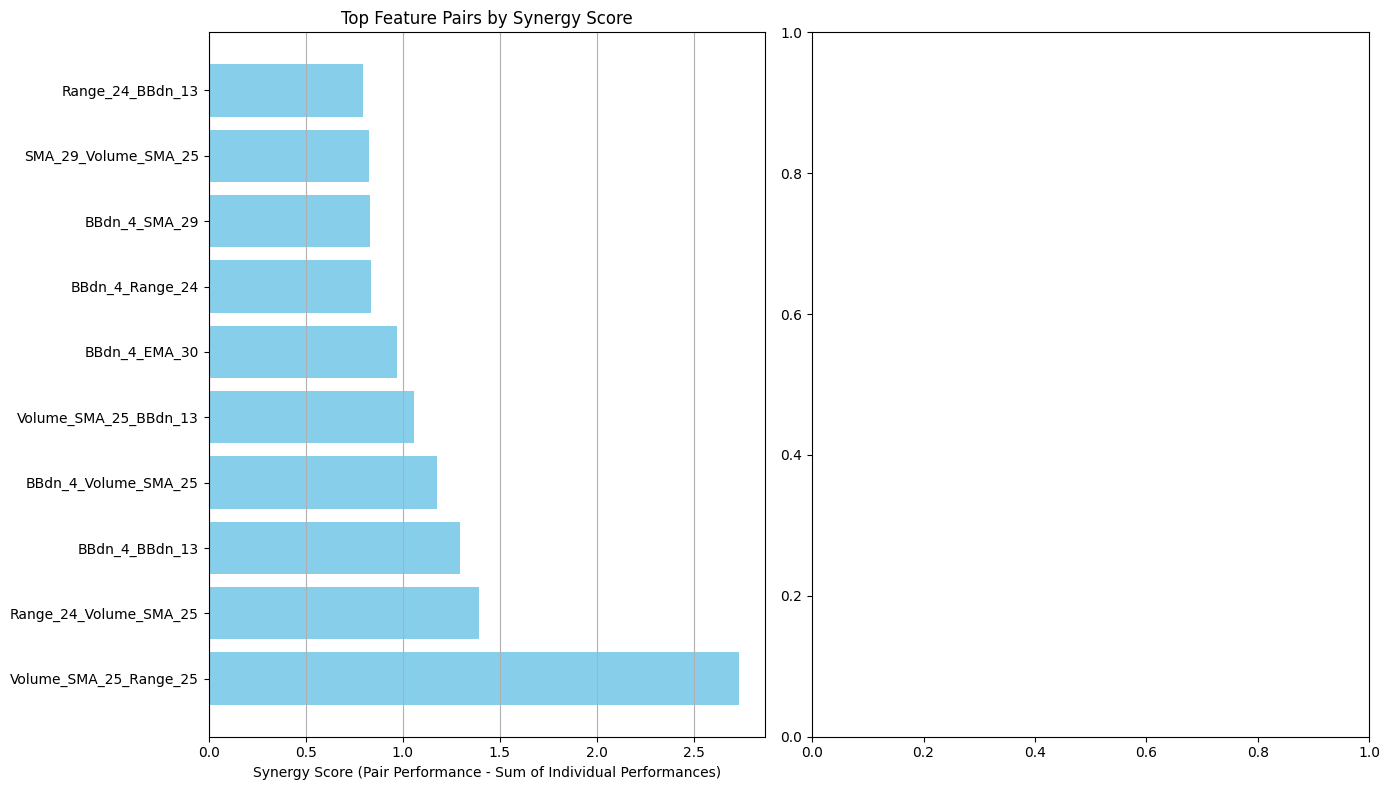

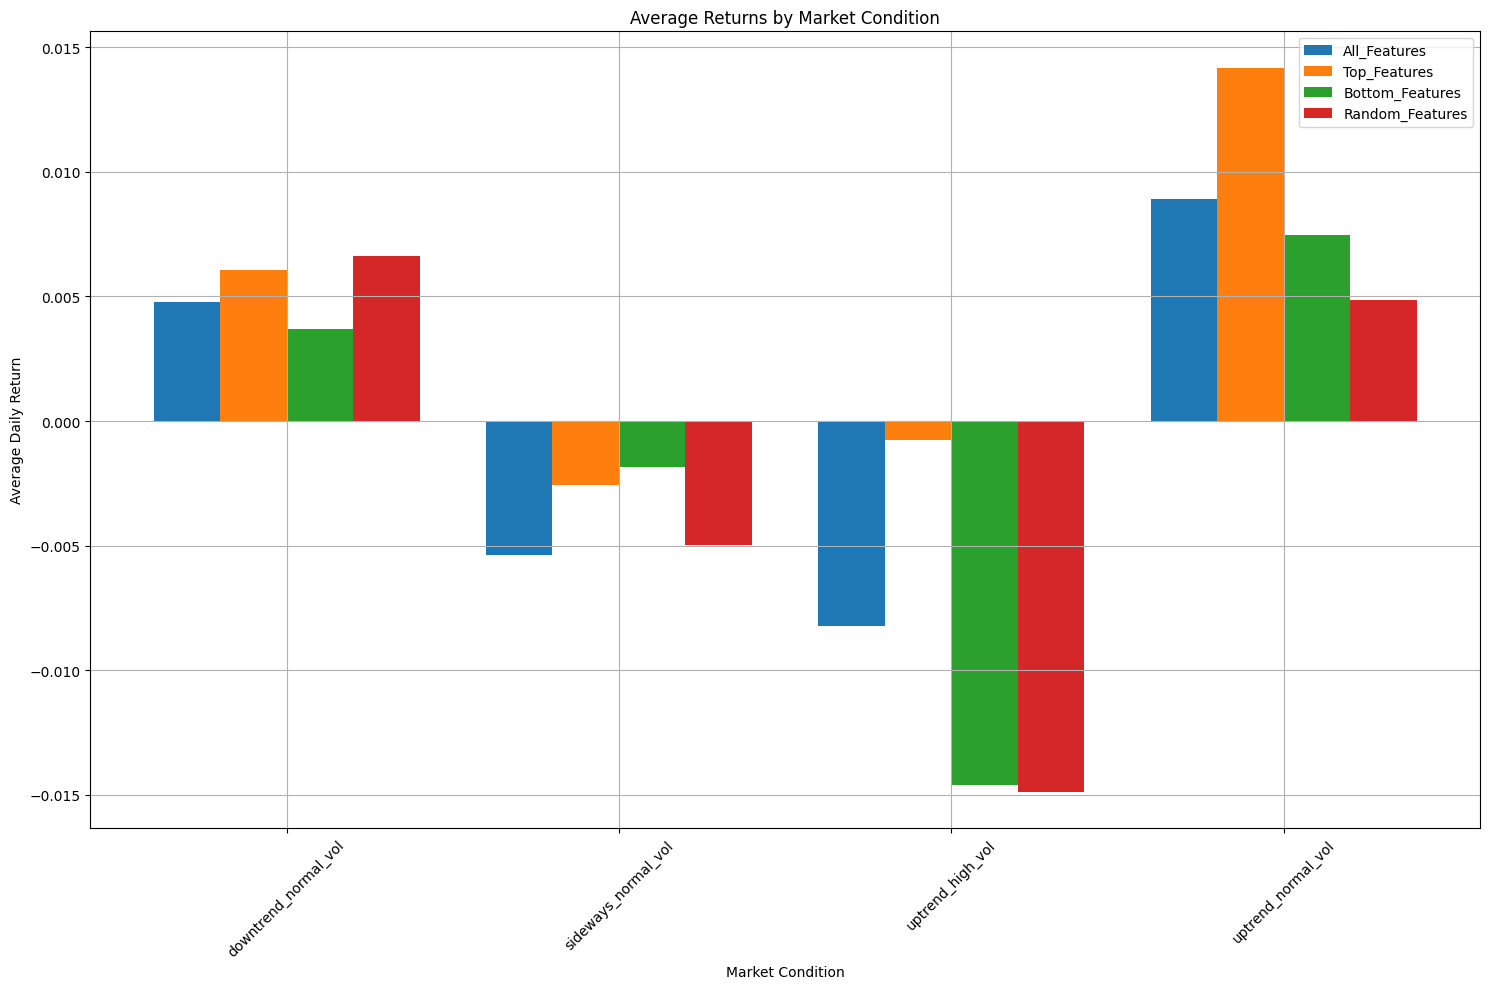

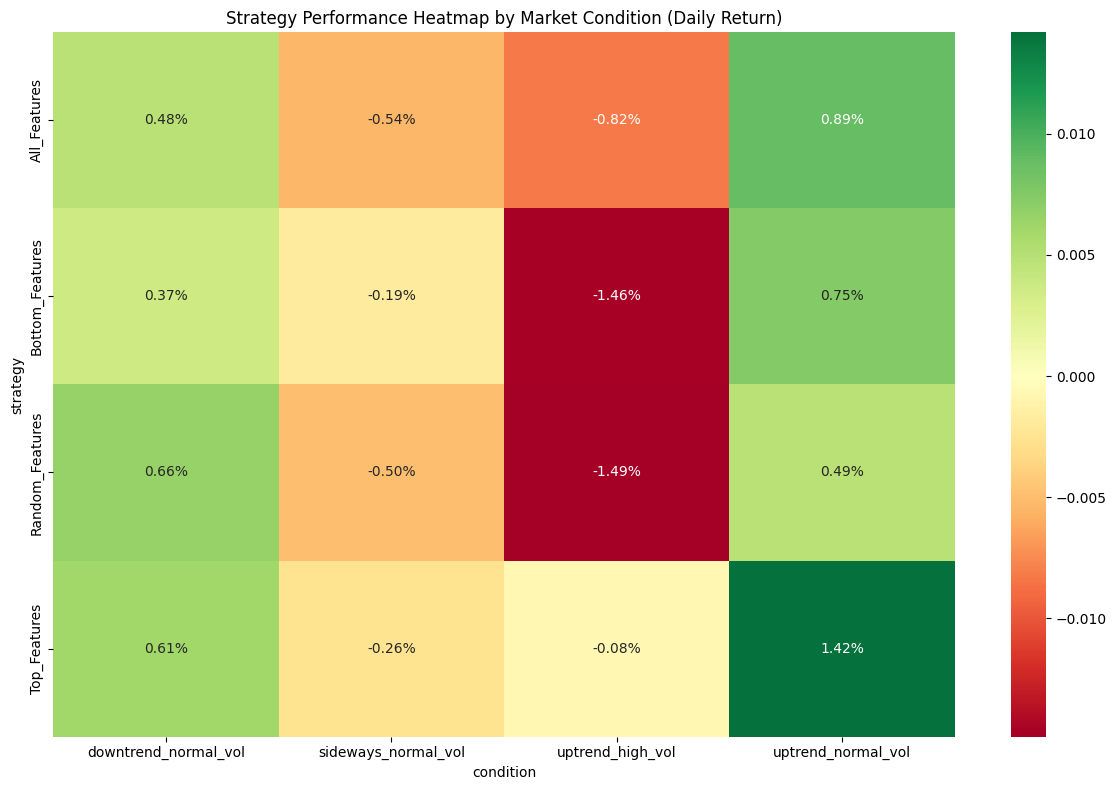

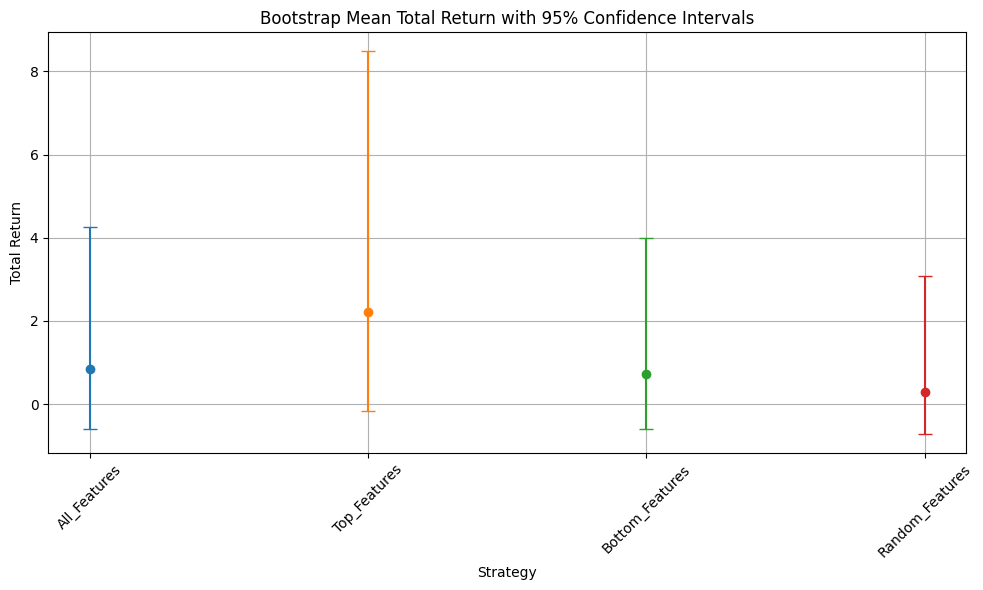

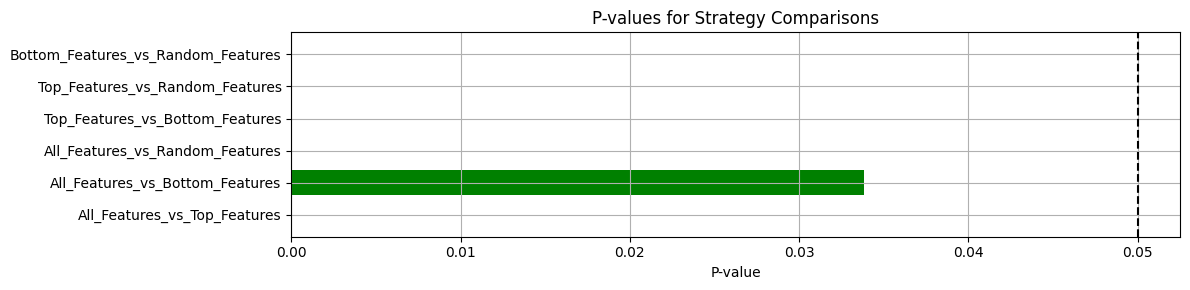

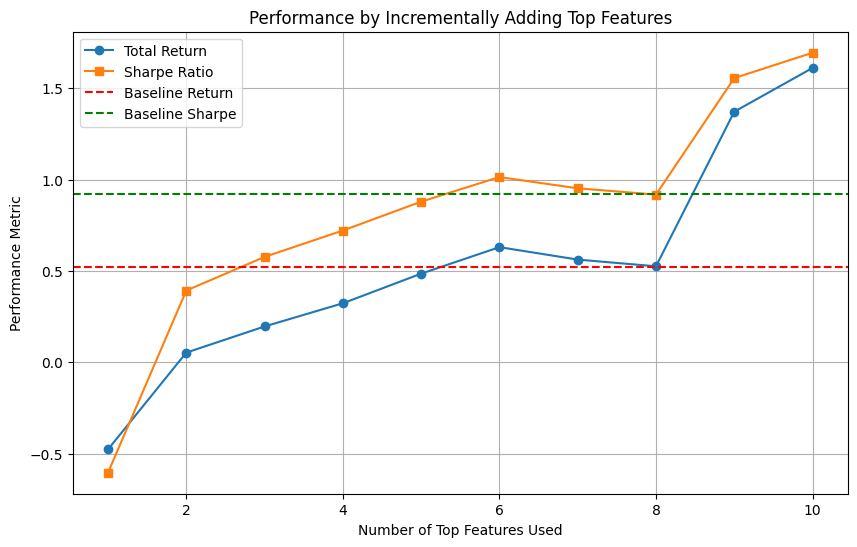

[INFO] Trading strategy evaluation results saved to ./XAI_results_a

[INFO] Complete analysis finished.


In [7]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='XAI-based Technical Indicator Analysis and Trading Performance Verification')
    
    parser.add_argument('--model_path', type=str, 
                        default="./checkpoints/treeMoE_TSLA_md5_hde32_al4_be1_mlp1_EXPNEW_0/checkpoint.pth",
                        help='Path to the trained model checkpoint')
    
    parser.add_argument('--gating_mode', type=str, choices=['hard', 'soft'], default='soft',
                        help='Gating mode (hard/soft)')
    
    parser.add_argument('--importance_type', type=str, choices=['phi_only', 'gamma_weight', 'both'], 
                        default='both', help='Importance extraction method')
    
    parser.add_argument('--stop_loss', type=int, choices=[0, 2, 3, 4, 5], default=0,
                        help='Stop loss period (0, 2, 3, 4, 5)')
    
    parser.add_argument('--top_k', type=int, default=10,
                        help='Number of top variables to select')
    
    parser.add_argument('--temperature', type=float, default=0.1,
                        help='Soft gating temperature parameter')
    
    parser.add_argument('--batch_size', type=int, default=8,
                        help='Data loader batch size')
    
    parser.add_argument('--output_dir', type=str, default='./XAI_results_a',
                        help='Result storage directory')
    
    args = parser.parse_args([])
    
    main(args)